In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta

import warnings
warnings.filterwarnings('ignore')

读取数据

In [38]:
train_data = pd.read_csv('train_public.csv')
submit_example = pd.read_csv('submit_example.csv')
test_public = pd.read_csv('test_public.csv')
train_inte = pd.read_csv('train_internet.csv')

pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)

In [39]:
train_data.head()

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon,isDefault
0,1040418,240418,31818.182,3,11.466,1174.910,C,政府机构,金融业,3 years,0,1,2016/10/1,2,193,13,2.430,0,556.364,649.091,3,0,0.000,7734.231,91.800,0,0,1-Dec,5,1,1.000,0.000,4.000,5.000,4.000,3,9927,0.000,0
1,1025197,225197,28000.000,5,16.841,670.690,C,政府机构,金融业,10+ years,0,2,2013/6/1,0,491,30,11.005,1,715.000,893.750,3,0,0.000,31329.000,54.800,1,0,Apr-90,40642,1,7.000,0.000,4.000,45.000,22.000,0,0,0.000,0
2,1009360,209360,17272.727,3,8.900,603.320,A,政府机构,公共服务、社会组织,10+ years,1,0,2014/1/1,4,459,8,6.409,0,774.545,903.636,5,0,0.000,18514.000,57.692,1,0,Oct-91,154,1,6.000,0.000,6.000,28.000,19.000,0,0,0.000,0
3,1039708,239708,20000.000,3,4.788,602.300,A,世界五百强,文化和体育业,6 years,0,1,2015/7/1,0,157,8,9.205,0,750.000,875.000,3,0,0.000,20707.000,42.600,0,0,1-Jun,0,1,5.000,0.000,10.000,15.000,9.000,0,0,0.000,0
4,1027483,227483,15272.727,3,12.790,470.310,C,政府机构,信息传输、软件和信息技术服务业,< 1 year,2,1,2016/7/1,0,38,21,15.578,0,609.091,710.606,15,0,0.000,14016.154,30.462,0,0,2-May,0,1,10.000,0.000,6.000,15.000,4.000,0,0,0.000,0


In [40]:
train_inte.head()

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,sub_class,work_type,employer_type,industry,work_year,house_exist,house_loan_status,censor_status,marriage,offsprings,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,pub_dero_bankrup,early_return,early_return_amount,early_return_amount_3mon,recircle_b,recircle_u,initial_list_status,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,f5,is_default
0,119262,0,12000.000,5,11.530,264.100,B,B5,职员,普通企业,采矿业,NaN,0,0,2,0,0,2015-06-01,0,814.000,4,5.070,1.000,670.000,674.000,1.000,0,0,0.000,3855.000,23.100,0,Mar-1984,0.000,1.000,1.000,0.000,8.000,17.000,8.000,1.000,1
1,369815,1,8000.000,3,13.980,273.350,C,C3,其他,普通企业,国际组织,10+ years,0,1,2,1,3,2010-10-01,2,240.000,21,15.040,0.000,725.000,729.000,0.000,0,0,0.000,118632.000,99.900,1,Jan-1992,94.000,1.000,NaN,NaN,NaN,NaN,NaN,NaN,0
2,787833,2,20000.000,5,17.990,507.760,D,D2,工人,上市企业,信息传输、软件和信息技术服务业,10+ years,0,0,1,0,0,2016-08-01,0,164.000,20,17.380,1.000,675.000,679.000,0.000,0,0,0.000,15670.000,72.500,0,Oct-1996,0.000,1.000,6.000,0.000,10.000,8.000,3.000,0.000,0
3,671675,3,10700.000,3,10.160,346.070,B,B1,职员,普通企业,电力、热力生产供应业,2 years,2,0,2,0,0,2013-05-01,4,48.000,10,27.870,0.000,710.000,714.000,0.000,0,0,0.000,18859.000,78.600,0,Jul-2000,41646.000,1.000,3.000,0.000,4.000,11.000,6.000,0.000,0
4,245160,4,8000.000,3,8.240,251.580,B,B1,其他,政府机构,金融业,5 years,1,2,0,0,0,2017-04-01,4,122.000,9,3.470,0.000,660.000,664.000,0.000,0,0,0.000,8337.000,67.800,1,Mar-2000,4.000,1.000,3.000,0.000,8.000,6.000,4.000,1.000,0


In [41]:
test_public.head()

,loan_id,user_id,total_loan,year_of_loan,interest,monthly_payment,class,employer_type,industry,work_year,house_exist,censor_status,issue_date,use,post_code,region,debt_loan_ratio,del_in_18month,scoring_low,scoring_high,known_outstanding_loan,known_dero,pub_dero_bankrup,recircle_b,recircle_u,initial_list_status,app_type,earlies_credit_mon,title,policy_code,f0,f1,f2,f3,f4,early_return,early_return_amount,early_return_amount_3mon
0,1000575,200575,2890.909,3,10.791,88.010,B,幼教与中小学校,住宿和餐饮业,5 years,0,1,2017/12/1,0,314,0,23.040,0,745.000,869.167,7,0,0.000,8647.692,31.846,1,0,3-Mar,0,1,2.000,0.000,15.000,5.000,4.000,3,773,89.192
1,1028125,228125,7272.727,3,9.990,258.100,B,普通企业,批发和零售业,10+ years,1,1,2015/7/1,5,29,19,27.755,0,681.818,738.636,24,0,0.000,9406.154,18.277,0,0,Dec-99,6,1,8.000,0.000,8.000,29.000,14.000,1,1894,218.538
2,1010694,210694,26295.455,3,15.763,764.030,C,普通企业,住宿和餐饮业,10+ years,0,2,2013/4/1,0,488,24,25.495,1,758.182,947.727,11,0,0.000,26414.769,62.300,1,0,Apr-99,268,1,6.000,0.000,4.000,10.000,6.000,1,5670,1221.231
3,1026712,226712,22690.909,5,19.305,524.300,D,普通企业,采矿业,10+ years,0,2,2017/12/1,0,489,30,10.620,0,572.727,620.455,8,0,0.000,1198.000,7.700,0,0,Jul-00,0,1,4.000,0.000,12.000,10.000,8.000,2,4800,443.077
4,1002895,202895,14545.455,3,7.139,490.320,A,世界五百强,金融业,1 year,0,0,2016/6/1,2,418,45,6.611,0,638.182,691.364,15,0,0.000,3920.000,8.831,1,0,7-May,5,1,4.000,0.000,7.000,14.000,9.000,0,3516,649.108


In [42]:
submit_example.head()

,id,isDefault
0,1000575,0
1,1028125,0
2,1010694,0
3,1026712,0
4,1002895,0


In [43]:
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0]) # 行数
    sub_preds = np.zeros(test_.shape[0])
    
    feature_importance_df = pd.DataFrame()
    # 去掉 贷款记录唯一标识 借款人唯一标识 是否违约 
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ] 
    
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        
        xgb = XGBClassifier(
            n_estimators = 4000,
            learning_rate = 0.08,
            num_leaves = 2**5,
            colsample_bytree = .65,
            subsample = .9,
            max_depth = 5,
#             max_bin=250,
            reg_alpha = .3,
            reg_lambda = .3,
            min_split_gain = .01,
            min_child_weight = 2,
            silent = -1,
            verbose = -1,
        )
        
        xgb.fit(trn_x, trn_y, 
                eval_set = [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric = 'auc', verbose = 100, early_stopping_rounds = 40  #30
               )

        oof_preds[val_idx] = xgb.predict_proba(val_x)[:, 1]
        sub_preds += xgb.predict_proba(test_[feats])[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = xgb.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis = 0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del xgb, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df

In [44]:
def workYearDIc(x):
    if str(x) == 'nan':
        return -1
    x = str(x).replace('< 1','0')
    return int(re.search('(\d+)', x).group())

In [45]:
def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'

处理日期类型&字符类型的列

In [46]:
class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}

timeMax = pd.to_datetime('1-Dec-21')
train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])



#Internet数据处理
train_inte['work_year'] = train_inte['work_year'].map(workYearDIc)
train_inte['class'] = train_inte['class'].map(class_dict)
train_inte['earlies_credit_mon'] = pd.to_datetime(train_inte['earlies_credit_mon'])
train_inte['issue_date'] = pd.to_datetime(train_inte['issue_date'])


train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year


###internet数据

train_inte['issue_date_month'] = train_inte['issue_date'].dt.month
train_inte['issue_date_dayofweek'] = train_inte['issue_date'].dt.dayofweek
train_inte['earliesCreditMon'] = train_inte['earlies_credit_mon'].dt.month
train_inte['earliesCreditYear'] = train_inte['earlies_credit_mon'].dt.year

处理category类型的列

In [47]:
cat_cols = ['employer_type', 'industry']

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    
    #Internet处理
    train_inte[col] = lbl.transform(train_inte[col])

[16:50:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "min_split_gain", "num_leaves", "silent", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.84238	validation_1-auc:0.84013
[90]	validation_0-auc:0.95242	validation_1-auc:0.89162
Fold  1 AUC : 0.891805
[16:50:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "min_split_gain", "num_leaves", "silent", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Ple

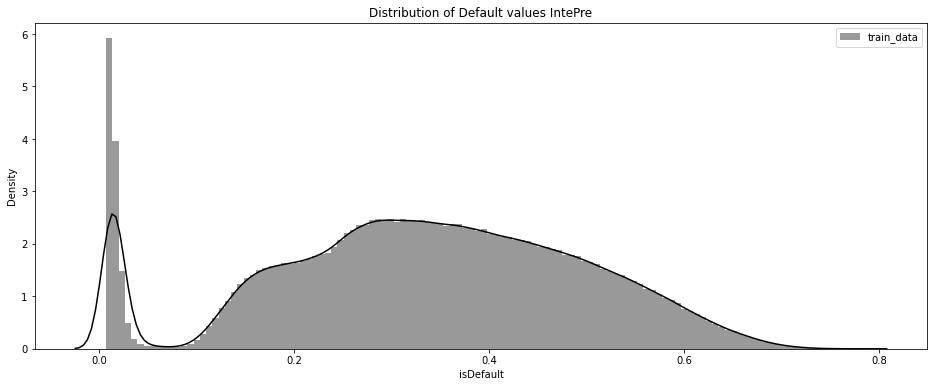

[16:50:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "min_split_gain", "num_leaves", "silent", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.97549	validation_1-auc:0.97081
[100]	validation_0-auc:0.99313	validation_1-auc:0.98507
[116]	validation_0-auc:0.99393	validation_1-auc:0.98496
Fold  1 AUC : 0.985119
[16:50:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "min_split_gain", "num_leaves", "silent", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter ac

In [48]:
# 'f1','policy_code','app_type' 这三个去掉是881
# ,'f1','policy_code','app_type'
col_to_drop = ['issue_date', 'earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1 )

##internet处理
train_inte = train_inte.drop(col_to_drop, axis=1 )
# 暂时不变
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})
# data = pd.concat( [train_data,test_public] )
tr_cols = set(train_data.columns)
same_col = list(tr_cols.intersection(set(train_inte.columns)))
train_inteSame = train_inte[same_col].copy()

Inte_add_cos = list(tr_cols.difference(set(same_col)))
for col in Inte_add_cos:
    train_inteSame[col] = np.nan

#81后加 
# for col in cat_cols:
#     dum = pd.get_dummies(data[col], prefix='OneHot_'+col +'_')
#     data = pd.concat([data, dum], axis=1)
# #     del data[col]
#     del dum

y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, IntePre, importances = train_model(train_data, train_inteSame, y, folds)

IntePre['isDef'] = train_inte['is_default']
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDef'],IntePre.isDefault)
## 选择阈值0.05，从internet表中提取预测小于该概率的样本，并对不同来源的样本赋予来源值
InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()

train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0
train_inteSame['isDefault'] = train_inte['is_default']
use_te = train_inteSame[train_inteSame.loan_id.isin( InteId )].copy()
data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)




# InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})

# train_data['dataSourse'] = 1
# test_public['dataSourse'] = 1
# train_inte['dataSourse'] = 0



# use_te = train_inte[train_inte.loan_id.isin( InteId )].copy()
# data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)

# IntePre.isDefault
plt.figure(figsize=(16,6))
plt.title("Distribution of Default values IntePre")
sns.distplot(IntePre['isDefault'],color="black", kde=True,bins=120, label='train_data')
# sns.distplot(train_inte[col],color="red", kde=True,bins=120, label='train_inte')
plt.legend();plt.show()
train = data[data['isDefault'].notna()]
test  = data[data['isDefault'].isna()]
# for col in ['sub_class', 'work_type']:
#     del train[col]
#     del test[col]


del data
del train_data,test_public


y = train['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, test_preds, importances = train_model(train, test, y, folds)
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('nn2_1028_1.csv', index=False)



In [49]:
import pandas as pd
train_data = pd.read_csv('train_public.csv')
test_data = pd.read_csv('test_public.csv')
sub = pd.read_csv("nn2.csv")
sub = sub.rename(columns={'id': 'loan_id'})
sub.loc[sub['isDefault'] < 0.5,'isDefault'] = 0
nw_sub = sub[(sub['isDefault'] == 0)]
nw_test_data = test_data.merge(nw_sub,on = 'loan_id',how = 'inner')
nw_train_data = pd.concat([train_data,nw_test_data]).reset_index(drop = True)
nw_train_data.to_csv("nw_train_public.csv",index = 0)

[16:52:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "min_split_gain", "num_leaves", "silent", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.84310	validation_1-auc:0.85075
[100]	validation_0-auc:0.95384	validation_1-auc:0.90419
[116]	validation_0-auc:0.96102	validation_1-auc:0.90292
Fold  1 AUC : 0.906477
[16:52:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "min_split_gain", "num_leaves", "silent", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter ac

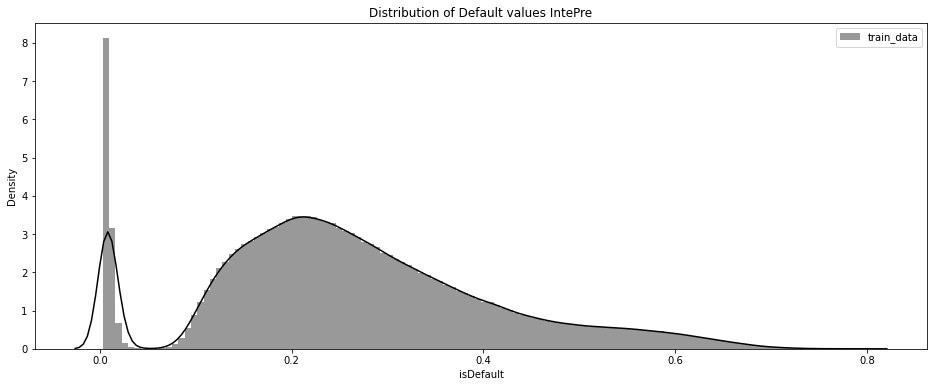

[16:52:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "min_split_gain", "num_leaves", "silent", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-auc:0.76189	validation_1-auc:0.76292
[100]	validation_0-auc:0.79036	validation_1-auc:0.78719
[200]	validation_0-auc:0.79782	validation_1-auc:0.79079
[300]	validation_0-auc:0.80225	validation_1-auc:0.79214
[400]	validation_0-auc:0.80614	validation_1-auc:0.79292
[500]	validation_0-auc:0.80934	validation_1-auc:0.79319
[600]	validation_0-auc:0.81234	validation_1-auc:0.79321
[700]	validation_0-auc:0.81532	validation_1-auc:0.79343
[800]	validation_0-auc:0.81813	validation_1-auc:0.79348
[900]	validation_0-auc:0.82103	validatio

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import re
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from sklearn.model_selection import StratifiedKFold
from dateutil.relativedelta import relativedelta
train_data = pd.read_csv('nw_train_public.csv')
submit_example = pd.read_csv('submit_example.csv')
test_public = pd.read_csv('test_public.csv')
train_inte = pd.read_csv('train_internet.csv')

pd.set_option('max_columns', None)
pd.set_option('max_rows', 200)
pd.set_option('float_format', lambda x: '%.3f' % x)
def train_model(data_, test_, y_, folds_):
    oof_preds = np.zeros(data_.shape[0])
    sub_preds = np.zeros(test_.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in data_.columns if f not in ['loan_id', 'user_id', 'isDefault'] ]
    for n_fold, (trn_idx, val_idx) in enumerate(folds_.split(data_)):
        trn_x, trn_y = data_[feats].iloc[trn_idx], y_.iloc[trn_idx]
        val_x, val_y = data_[feats].iloc[val_idx], y_.iloc[val_idx]
        xgb = XGBClassifier(
            n_estimators=4000,
            learning_rate=0.08,
            num_leaves=2**5,
            colsample_bytree=.65,
            subsample=.9,
            max_depth=5,
#             max_bin=250,
            reg_alpha=.3,
            reg_lambda=.3,
            min_split_gain=.01,
            min_child_weight=2,
            silent=-1,
            verbose=-1,
        )
        
        xgb.fit(trn_x, trn_y, 
                eval_set= [(trn_x, trn_y), (val_x, val_y)], 
                eval_metric='auc', verbose=100, early_stopping_rounds=40  #30
               )

        oof_preds[val_idx] = xgb.predict_proba(val_x)[:, 1]
        sub_preds += xgb.predict_proba(test_[feats])[:, 1] / folds_.n_splits
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = xgb.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
        del xgb, trn_x, trn_y, val_x, val_y
        gc.collect()
        
    print('Full AUC score %.6f' % roc_auc_score(y, oof_preds)) 
    
    test_['isDefault'] = sub_preds

    return oof_preds, test_[['loan_id', 'isDefault']], feature_importance_df
    
def display_importances(feature_importance_df_):
    # Plot feature importances
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)[:50].index
    
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    
    plt.figure(figsize=(8,10))
    sns.barplot(x="importance", y="feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')

def workYearDIc(x):
    if str(x)=='nan':
        return -1
    x = x.replace('< 1','0')
    return int(re.search('(\d+)', x).group())

def findDig(val):
    fd = re.search('(\d+-)', val)
    if fd is None:
        return '1-'+val
    return val + '-01'


class_dict = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5,
    'F': 6,
    'G': 7,
}
timeMax = pd.to_datetime('1-Dec-21')
train_data['work_year'] = train_data['work_year'].map(workYearDIc)
test_public['work_year'] = test_public['work_year'].map(workYearDIc)
train_data['class'] = train_data['class'].map(class_dict)
test_public['class'] = test_public['class'].map(class_dict)

train_data['earlies_credit_mon'] = pd.to_datetime(train_data['earlies_credit_mon'].map(findDig))
test_public['earlies_credit_mon'] = pd.to_datetime(test_public['earlies_credit_mon'].map(findDig))
train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = train_data.loc[ train_data['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+  pd.offsets.DateOffset(years=-100)  
test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ] = test_public.loc[ test_public['earlies_credit_mon']>timeMax,'earlies_credit_mon' ]+ pd.offsets.DateOffset(years=-100)
train_data['issue_date'] = pd.to_datetime(train_data['issue_date'])
test_public['issue_date'] = pd.to_datetime(test_public['issue_date'])



#Internet数据处理
train_inte['work_year'] = train_inte['work_year'].map(workYearDIc)
train_inte['class'] = train_inte['class'].map(class_dict)
train_inte['earlies_credit_mon'] = pd.to_datetime(train_inte['earlies_credit_mon'])
train_inte['issue_date'] = pd.to_datetime(train_inte['issue_date'])


train_data['issue_date_month'] = train_data['issue_date'].dt.month
test_public['issue_date_month'] = test_public['issue_date'].dt.month
train_data['issue_date_dayofweek'] = train_data['issue_date'].dt.dayofweek
test_public['issue_date_dayofweek'] = test_public['issue_date'].dt.dayofweek

train_data['earliesCreditMon'] = train_data['earlies_credit_mon'].dt.month
test_public['earliesCreditMon'] = test_public['earlies_credit_mon'].dt.month
train_data['earliesCreditYear'] = train_data['earlies_credit_mon'].dt.year
test_public['earliesCreditYear'] = test_public['earlies_credit_mon'].dt.year


###internet数据

train_inte['issue_date_month'] = train_inte['issue_date'].dt.month
train_inte['issue_date_dayofweek'] = train_inte['issue_date'].dt.dayofweek
train_inte['earliesCreditMon'] = train_inte['earlies_credit_mon'].dt.month
train_inte['earliesCreditYear'] = train_inte['earlies_credit_mon'].dt.year


cat_cols = ['employer_type', 'industry']

from sklearn.preprocessing import LabelEncoder
for col in cat_cols:
    lbl = LabelEncoder().fit(train_data[col])
    train_data[col] = lbl.transform(train_data[col])
    test_public[col] = lbl.transform(test_public[col])
    
    #Internet处理
    train_inte[col] = lbl.transform(train_inte[col])
    
# 'f1','policy_code','app_type' 这三个去掉是881
# ,'f1','policy_code','app_type'
col_to_drop = ['issue_date', 'earlies_credit_mon']
train_data = train_data.drop(col_to_drop, axis=1)
test_public = test_public.drop(col_to_drop, axis=1 )

##internet处理
train_inte = train_inte.drop(col_to_drop, axis=1 )
# 暂时不变
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})
# data = pd.concat( [train_data,test_public] )
tr_cols = set(train_data.columns)
same_col = list(tr_cols.intersection(set(train_inte.columns)))
train_inteSame = train_inte[same_col].copy()

Inte_add_cos = list(tr_cols.difference(set(same_col)))
for col in Inte_add_cos:
    train_inteSame[col] = np.nan

#81后加 
# for col in cat_cols:
#     dum = pd.get_dummies(data[col], prefix='OneHot_'+col +'_')
#     data = pd.concat([data, dum], axis=1)
# #     del data[col]
#     del dum

y = train_data['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, IntePre, importances = train_model(train_data, train_inteSame, y, folds)

IntePre['isDef'] = train_inte['is_default']
from sklearn.metrics import roc_auc_score
roc_auc_score(IntePre['isDef'],IntePre.isDefault)
## 选择阈值0.05，从internet表中提取预测小于该概率的样本，并对不同来源的样本赋予来源值
InteId = IntePre.loc[IntePre.isDefault<0.5, 'loan_id'].tolist()

train_data['dataSourse'] = 1
test_public['dataSourse'] = 1
train_inteSame['dataSourse'] = 0
train_inteSame['isDefault'] = train_inte['is_default']
use_te = train_inteSame[train_inteSame.loan_id.isin( InteId )].copy()
data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)




# InteId = IntePre.loc[IntePre.isDefault<0.05, 'loan_id'].tolist()
# train_inte = train_inte.rename(columns={'is_default':'isDefault'})

# train_data['dataSourse'] = 1
# test_public['dataSourse'] = 1
# train_inte['dataSourse'] = 0



# use_te = train_inte[train_inte.loan_id.isin( InteId )].copy()
# data = pd.concat([ train_data,test_public,use_te]).reset_index(drop=True)

# IntePre.isDefault
plt.figure(figsize=(16,6))
plt.title("Distribution of Default values IntePre")
sns.distplot(IntePre['isDefault'],color="black", kde=True,bins=120, label='train_data')
# sns.distplot(train_inte[col],color="red", kde=True,bins=120, label='train_inte')
plt.legend();plt.show()
train = data[data['isDefault'].notna()]
test  = data[data['isDefault'].isna()]
# for col in ['sub_class', 'work_type']:
#     del train[col]
#     del test[col]


del data
del train_data,test_public


y = train['isDefault']
folds = KFold(n_splits=5, shuffle=True, random_state=546789)
oof_preds, test_preds, importances = train_model(train, test, y, folds)
test_preds.rename({'loan_id': 'id'}, axis=1)[['id', 'isDefault']].to_csv('baseline891_1028_1.csv', index=False)
